In [1]:
import pandas as pd
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc


C:\Users\Javi\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import random

def replace_ambiguous_bases(sequence):
    def resolve_ambiguity(code):
        if code == 'R':
            return random.choice(['A', 'G'])
        elif code == 'Y':
            return random.choice(['C', 'T'])
        elif code == 'S':
            return random.choice(['G', 'C'])
        elif code == 'W':
            return random.choice(['A', 'T'])
        elif code == 'K':
            return random.choice(['G', 'T'])
        elif code == 'M':
            return random.choice(['A', 'C'])
        elif code == 'B':
            return random.choice(['C', 'G', 'T'])
        elif code == 'D':
            return random.choice(['A', 'G', 'T'])
        elif code == 'H':
            return random.choice(['A', 'C', 'T'])
        elif code == 'V':
            return random.choice(['A', 'C', 'G'])
        elif code == 'N':
            return random.choice(['A', 'T', 'C', 'G'])
        else:
            return code  # If the code is not an ambiguity code, return the same code
    
    resolved_sequence = ''.join(resolve_ambiguity(base) for base in sequence)
    return resolved_sequence

In [3]:
#This function gets the cgr for the sequences
def easy_cgr(dna_sequence):
  nucleotide_map = {
    "A": (1, 1),
    "T": (-1, -1),
    "C": (1, -1),
    "G": (-1, 1),
}
  values=[]
  point=(0,0)
  for nucleotide in dna_sequence:
        next_point=nucleotide_map[nucleotide]
        point=((point[0]+next_point[0])/2,(point[1]+next_point[1])/2)
        values.append(point)
  return values

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def plotting_cgr(sequence_to_plot,id_to_plot,resolution):

  # Define the resolution
  num_bins = resolution

  # Create a grid for the histogram
  xedges = np.linspace(-1, 1, num_bins + 1)
  yedges = np.linspace(-1, 1, num_bins + 1)

  # Create a 2D histogram
  hist, _, _ = np.histogram2d([p[0] for p in sequence_to_plot], [p[1] for p in sequence_to_plot], bins=[xedges, yedges])

  # Create a custom colormap spanning from light gray to dark gray
  colors = [(1, 1, 1), (0.2, 0.2, 0.2)]  # Light gray to dark gray
  cmap_name = "custom_gray"
  custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=len(sequence_to_plot) + 1)

  # Create a figure
  plt.figure()

  # Display the 2D histogram with the custom colormap
  plt.imshow(hist.T, cmap=custom_cmap, extent=[-1, 1, -1, 1], origin='lower', interpolation='nearest', aspect='auto')

  # Calculate coordinates for labels
  plt.xticks([])
  plt.yticks([])
  x_margin, y_margin = 0.05, 0.05
  label_coordinates = {
      "A": (1+ x_margin, 1 +y_margin),
      "T": (-1 - x_margin, -1-y_margin),
      "C": (1 + x_margin, -1 -y_margin),
      "G": (-1 - x_margin, 1 + y_margin),
  }

  # Add labels outside the grid
  for letter, (x, y) in label_coordinates.items():
      plt.text(x, y, letter, ha='center', va='center', fontsize=15, color='black')
  # Show the plot
  plt.title('CGR for '+id_to_plot)
  plt.grid(False)  # Turn off grid lines
  plt.show()

In [5]:
#This function reads the file when usingantibiotic resistance genes
import re

def read_antibiotic_resistance_genes(fasta_file_path):
    # Initialize lists to store sequence data
    sequence_ids = []
    sequences = []
    terms_inside_brackets = []  # Initialize a list to store terms inside brackets

    # Define a regular expression pattern to match text inside square brackets
    pattern = r'\[([^]]+)\]'

    # Open the FASTA file for reading
    with open(fasta_file_path, "r") as file:
        for line in file:
            line = line.strip()  # Remove leading/trailing whitespace

            # Check if the line is an ID line (starts with '>')
            if line.startswith(">"):
                # If it's not the first sequence, process the previous one
                if sequence_ids:
                    term_inside_brackets = re.search(pattern, sequence_ids[-1]).group(1)
                    terms_inside_brackets.append(term_inside_brackets)  # Append to the list
                # Extract the sequence ID from the ID line
                sequence_ids.append(line[1:])
                sequences.append("")  # Reset the sequence
            else:
                # Append the line to the sequence
                sequences[-1] += line

    # Process the last sequence in the file
    if sequence_ids:
        term_inside_brackets = re.search(pattern, sequence_ids[-1]).group(1)
        terms_inside_brackets.append(term_inside_brackets)

    return sequences, terms_inside_brackets

In [9]:

def read_fasta_ARG(file_name):
    sequences = []
    with open(file_name, 'r') as file:
        sequence_id = ''
        sequence = ''
        for line in file:
            line = line.strip()
            if line.startswith('>'):
                if sequence_id != '':
                    sequences.append(sequence_id.split('|') + [sequence])
                sequence_id = line[1:]
                sequence = ''
            else:
                sequence += line
        if sequence_id != '':
            sequences.append(sequence_id.split('|') + [sequence])
    return sequences


### READ ANTIBIOTICS

In [10]:

file_name = "AntibioticResistanceGenes.fasta"
fasta_sequences = read_fasta_ARG(file_name)

# Convert to DataFrame
data_antibiotic = pd.DataFrame(fasta_sequences, columns=['ID Prefix', 'ID', 'Strand', 'Location',"ARO", 'Description', 'Sequence'])


data_antibiotic["Description"] = data_antibiotic["Description"].str.replace(' ', '_')
data_antibiotic.rename(columns={'Description': 'ids', 'Sequence': 'seq'}, inplace=True)

df_ids_antibiotics = data_antibiotic[["ids", "seq"]]

### 

In [11]:
df_ids_antibiotics

,ids,seq
0,CblA-1_[mixed_culture_bacterium_AX_gF3SD01_15],ATGAAAGCATATTTCATCGCCATACTTACCTTATTCACTTGTATAG...
1,SHV-52_[Klebsiella_pneumoniae],ATGCGTTATATTCGCCTGTGTATTATCTCCCTGTTAGCCGCCCTGC...
2,dfrF_[Enterococcus_faecalis],ATGATAGGTTTGATTGTTGCGAGGTCAAAGAATAATGTTATAGGCA...
3,CTX-M-130_[Escherichia_coli],ATGGTGACAAAGAGAGTGCAACGGATGATGTTCGCGGCGGCGGCGT...
4,NDM-6_[Escherichia_coli],ATGGAATTGCCCAATATTATGCACCCGGTCGCGAAGCTGAGCACCG...
...,...,...
5063,Mfer_23S_MAC_[Mycoplasmopsis_fermentans_PG18],CTTTTAAACCGATCGATTTATTAGTATTGGTCAGCTCAACGTATTA...
5064,Ecol_16S_TET_[Escherichia_coli_str._K-12],AAATTGAAGAGTTTGATCATGGCTCAGATTGAACGCTGGCGGCAGG...
5065,Ecol_16rrsH_SPT_[Escherichia_coli_str._K-12],AAATTGAAGAGTTTGATCATGGCTCAGATTGAACGCTGGCGGCAGG...
5066,Crei_16rrnS_STR_[Chlamydomonas_reinhardtii],ATCCATGGAGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCAT...


In [12]:
import pandas as pd

# Assuming df_ids_antibiotics is your DataFrame
df_ids_antibiotics_sorted = df_ids_antibiotics.assign(seq_length=df_ids_antibiotics['seq'].str.len()).sort_values(by='seq_length')

# Drop the temporary column seq_length if needed
#df_ids_antibiotics_sorted = df_ids_antibiotics_sorted.drop(columns=['seq_length'])

# Now df_ids_antibiotics_sorted contains rows sorted by the length of strings in the "seq" column from smallest to largest


In [13]:
df_ids_antibiotics_sorted

,ids,seq,seq_length
2207,ArmR_[Pseudomonas_aeruginosa_PAO1],ATGTCCCTGAACACTCCGCGCAACAAACCGTCCCGCACCGAGACCG...,162
2637,rsmA_[Pseudomonas_aeruginosa],ATGCTGATTCTGACTCGTCGGGTCGGAGAGACCCTGATGGTAGGTG...,186
4562,vanU_in_vanG_cl_[Enterococcus_faecalis],ATGCGTGTTAGTTATAATAAGCTCTGGAAGCTTTTAATTGATAGGG...,228
4744,almF_[Vibrio_cholerae],ATGAAACAAGCCATTGAAAATATTCTTATTGAGCGATTACAAACCA...,237
658,dfrB1_[Escherichia_coli],ATGGAACGAAGTAGCAATGAAGTCAGTAATCCAGTTGCTGGCAATT...,237
...,...,...,...
4921,Cdif_rpoB_RIF_[Clostridium_ljungdahlii_DSM_13528],ATGGTACATCCTGTCCAGGTTGGTAAAAGAACAAGAATGAGCTTTT...,3729
4865,Mlep_gyrA_FLO_[Mycobacterium_leprae_TN],ATGACTGATATCACGCTGCCACCAGGTGACGGTTCTATACAGCGGG...,3750
4820,Ecol_rpoB_RIF_[Escherichia_coli_O157:H7_str._S...,ATGGTTTACTCCTATACCGAGAAAAAACGTATTCGTAAGGATTTTG...,4029
2051,abcA_[Aspergillus_fumigatus_Af293],ATGAATGAAAGTCATGAAGCTGGAAAAAATTCCTCTACCAATGTGG...,4359


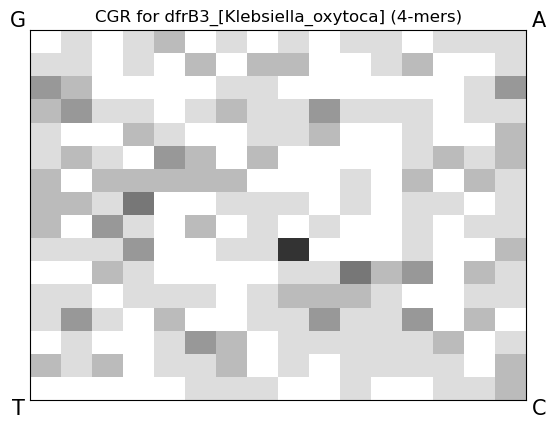

In [37]:
i=5
sequence_to_plot = df_ids_antibiotics_sorted.iloc[i]['seq']
sequence_to_plot_final= replace_ambiguous_bases(sequence_to_plot)
cgr_to_plot=easy_cgr(sequence_to_plot_final)
id_to_plot = df_ids_antibiotics_sorted.iloc[i]['ids'] +" (4-mers)"
resolution=2**4
plotting_cgr(cgr_to_plot,id_to_plot,resolution)


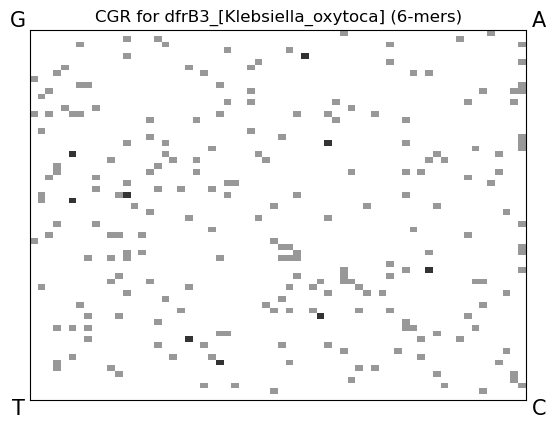

In [38]:
i=5
sequence_to_plot = df_ids_antibiotics_sorted.iloc[i]['seq']
sequence_to_plot_final= replace_ambiguous_bases(sequence_to_plot)
cgr_to_plot=easy_cgr(sequence_to_plot_final)
id_to_plot = df_ids_antibiotics_sorted.iloc[i]['ids'] +" (6-mers)"
resolution=2**6
plotting_cgr(cgr_to_plot,id_to_plot,resolution)

In [34]:
len(sequence_to_plot)

237

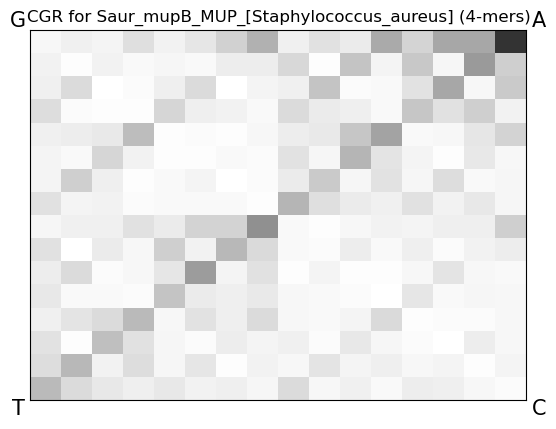

In [40]:
i=5010
sequence_to_plot = df_ids_antibiotics_sorted.iloc[i]['seq']
sequence_to_plot_final= replace_ambiguous_bases(sequence_to_plot)
cgr_to_plot=easy_cgr(sequence_to_plot_final)
id_to_plot = df_ids_antibiotics_sorted.iloc[i]['ids'] +" (4-mers)"
resolution=2**4
plotting_cgr(cgr_to_plot,id_to_plot,resolution)


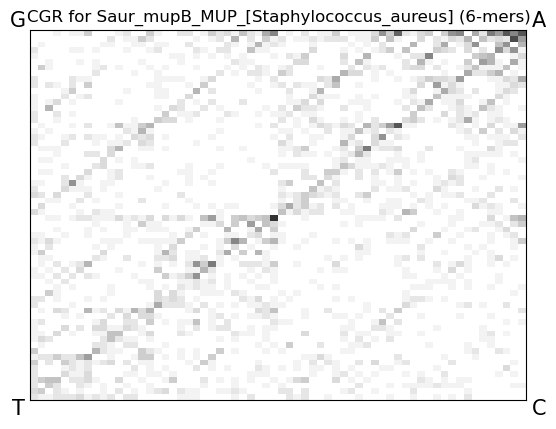

In [39]:
i=5010
sequence_to_plot = df_ids_antibiotics_sorted.iloc[i]['seq']
sequence_to_plot_final= replace_ambiguous_bases(sequence_to_plot)
cgr_to_plot=easy_cgr(sequence_to_plot_final)
id_to_plot = df_ids_antibiotics_sorted.iloc[i]['ids'] +" (6-mers)"
resolution=2**6
plotting_cgr(cgr_to_plot,id_to_plot,resolution)

In [41]:
len(sequence_to_plot)

3102